In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape

from tensorflow.keras.datasets import fashion_mnist

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], [
            tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 512 * 1)
        ]
    )

In [4]:
print ('TF Version :', tf.__version__)

TF Version : 2.7.0


### Utility Function

In [5]:
def __func_plot(title, dataset, list_of_index=None):
    
    # random index of dataset
    if list_of_index == None:
        list_of_index = np.random.randint(dataset.shape[0], size=4).tolist()
    
    # set figure
    plt.figure(figsize=(16, 3))
    
    for c, i in enumerate(list_of_index):
        
        # subplot
        ax = plt.subplot(1, len(list_of_index), c + 1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # plot
        plt.gray()
        plt.title(title)
        plt.imshow(dataset[i])
    
    # show
    plt.show()

# 1. Setup Dataset

#### - Original Image

In [6]:
# Download Dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [7]:
# Normalization Dataset -> [0, 1]
x_train = x_train / 255.
x_test = x_test / 255.

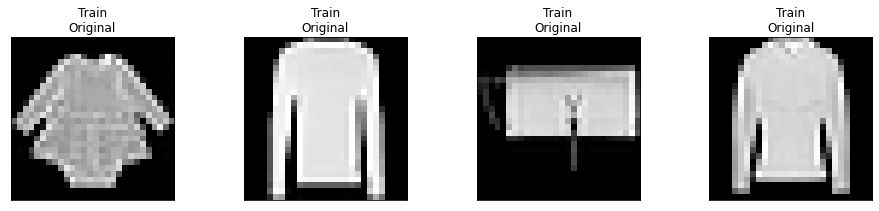

In [8]:
# Dataset Plot
__func_plot('Train\nOriginal', x_train)

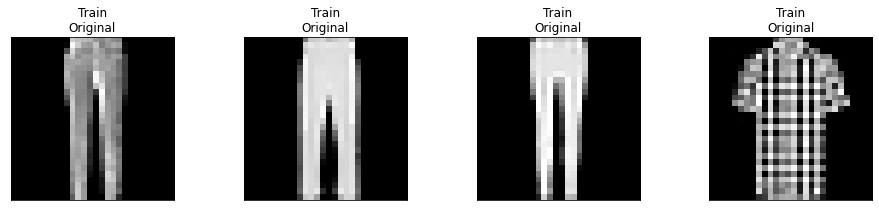

In [9]:
# Dataset Plot
__func_plot('Train\nOriginal', x_test)

#### - Intelligent Image

In [10]:
# Set Noise Factor
noise_factor = 0.2

# Set a noisy train dataset.
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

# Set a noisy test dataset.
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

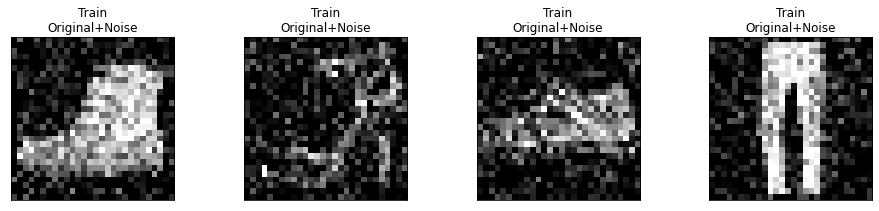

In [11]:
# Dataset Plot
__func_plot('Train\nOriginal+Noise', x_train_noisy)

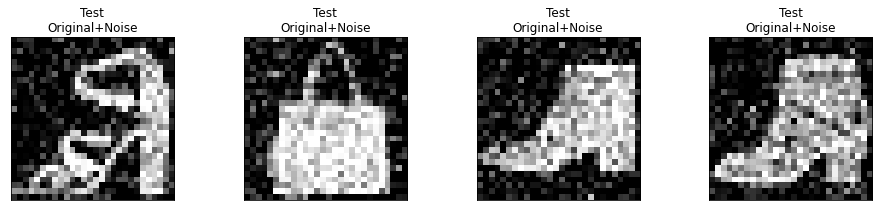

In [12]:
# Dataset Plot
__func_plot('Test\nOriginal+Noise', x_test_noisy)

# 2. Setup Model

#### - Free Memory

In [13]:
tf.keras.backend.clear_session()

#### - Encoder

In [14]:
# inputs
inputs = Input(shape=(28, 28, 1), name='Inputs')

# layers
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2, name='layers-1')(inputs)
x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2, name='layers-2')(x)

# latents / flatten
latents = Flatten(name='Latents')(x)

# encoder
encoder = Model(inputs, latents, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 layers-1 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 layers-2 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 Latents (Flatten)           (None, 784)               0         
                                                                 
Total params: 4,944
Trainable params: 4,944
Non-trainable params: 0
_________________________________________________________________


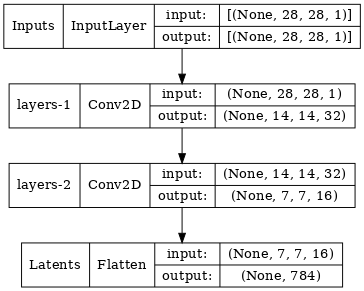

In [15]:
tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=69)

#### - Decoder

In [16]:
# latents
latents = Input(shape=(784), name='Latents')

# latents / reshape
x = Reshape((7, 7, 16), name='Reshape')(latents)

# layers
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2, name='layers-1')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2, name='layers-2')(x)

# outputs
outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='Outputs')(x)

# decoder
decoder = Model(latents, outputs, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Latents (InputLayer)        [(None, 784)]             0         
                                                                 
 Reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 layers-1 (Conv2DTranspose)  (None, 14, 14, 16)        2320      
                                                                 
 layers-2 (Conv2DTranspose)  (None, 28, 28, 32)        4640      
                                                                 
 Outputs (Conv2D)            (None, 28, 28, 1)         289       
                                                                 
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
_________________________________________________________________


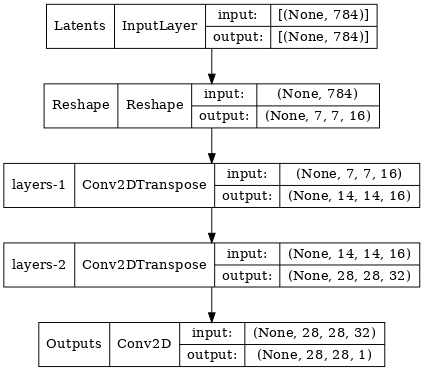

In [17]:
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi=69)

#### - Autoencoder

In [18]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='Autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 784)               4944      
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         7249      
                                                                 
Total params: 12,193
Trainable params: 12,193
Non-trainable params: 0
_________________________________________________________________


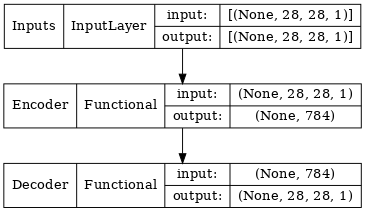

In [19]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=69)

# 3. Model Training

In [20]:
# model fit
history = autoencoder.fit(x_train_noisy, x_train, epochs=40, validation_split=0.2)

Epoch 1/40
1500/1500 [==============================] - 9s 4ms/step - loss: 0.0146 - val_loss: 0.0080
Epoch 2/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 3/40
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 4/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 5/40
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 6/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 7/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 8/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 9/40
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 10/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.005

<AxesSubplot:>

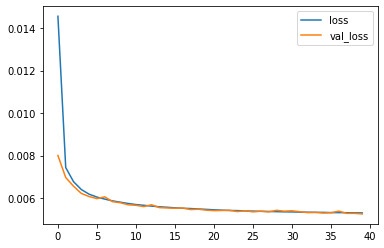

In [21]:
# model performance
pd.DataFrame(autoencoder.history.history).plot()

# 4. Model Evaluation

In [22]:
# model predict
y_pred = autoencoder.predict(x_test_noisy)

In [23]:
# get list_of_index
list_of_index = np.random.randint(x_test.shape[0], size=5).tolist()

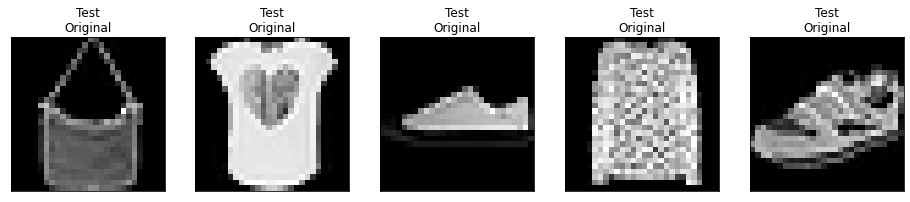

In [24]:
# Dataset Plot
__func_plot('Test\nOriginal', x_test, list_of_index)

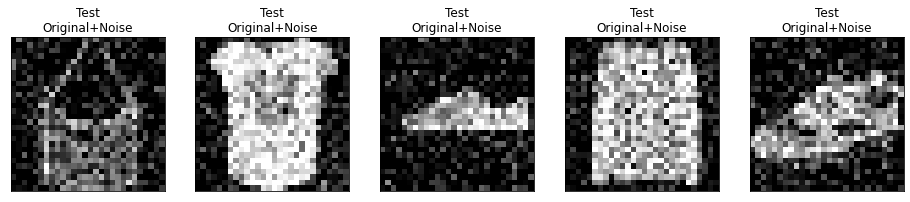

In [25]:
# Dataset Plot
__func_plot('Test\nOriginal+Noise', x_test_noisy, list_of_index)

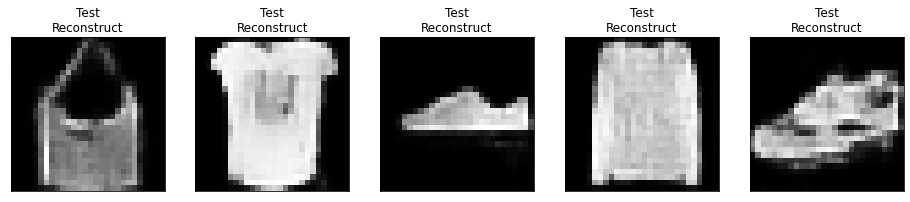

In [26]:
# Dataset Plot
__func_plot('Test\nReconstruct', y_pred, list_of_index)